# AI Commando Course, Cambridge 2018

## Session 1: Explaining Titanic Hypothesis with Decision Trees

_The problem we would like to solve is to determine if a Titanic's passenger would have survived, given age, passenger class, and sex. We will work with the Titanic dataset that can be downloaded from http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic.txt._

Start by importing numpy, scikit-learn, and pyplot, the Python libraries we will be using in this chapter. Show the versions we will be using (in case you have problems running the notebooks).

In [1]:
import IPython
import sklearn as sk
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pydot # don't use original pydot here
import pyparsing

print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sk.__version__)
print ('matplotlib version:', matplotlib.__version__)
#print ('pydot version:', pydotplus.__version__)
print ('pyparsing version:', pyparsing.__version__)

IPython version: 6.2.1
numpy version: 1.13.3
scikit-learn version: 0.19.1
matplotlib version: 2.1.0
pyparsing version: 2.2.0


### Preprocessing

As usual, we should first load the dataset. The list of attributes it includes is: Ordinal, Class, Survived (0=no, 1=yes), Name, Age, Port of Embarkation, Home/Destination, Room, Ticket, Boat, and Sex. We will start by loading the dataset into a numpy array.. We assume it is located in the data/titanic.csv file

In [2]:
import csv
with open('data/titanic.csv') as csvfile:
    titanic_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    # Header contains feature names
    row = next(titanic_reader)
    feature_names = np.array(row)
    
    # Load dataset, and target classes
    titanic_X, titanic_y = [], []
    for row in titanic_reader:  
        titanic_X.append(row)
        titanic_y.append(row[2]) # The target value is "survived"
    
    titanic_X = np.array(titanic_X)
    titanic_y = np.array(titanic_y)


Let's inspect how data looks. 

In [3]:
print (feature_names,"\n", titanic_X[0],"\n", titanic_y[0],"\n")


['row.names' 'pclass' 'survived' 'name' 'age' 'embarked' 'home.dest' 'room'
 'ticket' 'boat' 'sex'] 
 ['1' '1st' '1' 'Allen, Miss Elisabeth Walton' '29.0000' 'Southampton'
 'St Louis, MO' 'B-5' '24160 L221' '2' 'female'] 
 1 



We will keep only class (1st,2nd,3rd), age (float), and sex (male, female) for our study. 

In [4]:
# we keep the class, the age and the sex
titanic_X = titanic_X[:, [1, 4, 10]]
feature_names = feature_names[[1, 4, 10]]
print(feature_names)
print(titanic_X[12], titanic_y[12])


['pclass' 'age' 'sex']
['1st' 'NA' 'female'] 1


We have some problems with missing values ('NA') for the 'age' feature. To avoid this, we will use the mean value whenever we do not have data available.

In [5]:
ages = titanic_X[:, 1]
mean_age = np.mean(titanic_X[ages != 'NA', 1].astype(np.float))
titanic_X[titanic_X[:, 1] == 'NA', 1] = mean_age
print(feature_names)
print(titanic_X[12], titanic_y[12])


['pclass' 'age' 'sex']
['1st' '31.19418104265403' 'female'] 1


Now, class and sex are categorical classes, but most scikit-learn classifiers (in particular the Decision Trees we plan to use), expect real-valued attributes. We can easily convert sex  to a binary value (0=female,1=male). We will use the LabelEncoder class from scikit-learn:

In [6]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
label_encoder = enc.fit(titanic_X[:, 2])
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)
print ("Integer classes:", integer_classes)
t = label_encoder.transform(titanic_X[:, 2])
titanic_X[:, 2] = t
print ('Feature names:',feature_names)
print ('Features for instance number 12:',titanic_X[12], titanic_y[12])

Categorical classes: ['female' 'male']
Integer classes: [0 1]
Feature names: ['pclass' 'age' 'sex']
Features for instance number 12: ['1st' '31.19418104265403' '0'] 1


Now to convert the passenger class. Since we have three different categories, we cannot convert to binary values (and using 0,1,2 values would imply an order, something we do not want). We use OneHotEncoder to get three different attributes:

In [7]:
from sklearn.preprocessing import OneHotEncoder

#rjm49 - start by converting the pclass labels (column 0) into integer labels
#lab_enc = LabelEncoder()
label_encoder = LabelEncoder().fit(titanic_X[:, 0])
print("Categorical classes:", label_encoder.classes_)
integer_classes = label_encoder.transform(label_encoder.classes_)#.reshape(3, 1)
print("Integer classes:", integer_classes)

#rjm49 - get the integer labels for all the passengers
int_labels = label_encoder.transform(titanic_X[:,0]).reshape(-1,1)
print("int_labels:\n", int_labels)

#rjm49 - next, convert integer labels into "one hot" flags e.g. 0->[1 0 0], 1->[0 1 0], 2->[0 0 1]
onehot_enc = OneHotEncoder()
onehot_enc.fit(integer_classes.reshape(3, 1)) #rjm49 - note that this expects the classes to be passed in as a 3x1

# Second, create a sparse matrix with three columns, each one indicating if the instance belongs to the class
new_features = onehot_enc.transform( int_labels ).toarray() #rjm49 - ...and without the .toarray()?
print("new_features are:\n", new_features)

titanic_X = np.concatenate([titanic_X, new_features], axis = 1) # rjm49, add the three new columns

#Delete the old columns which have now been converted
titanic_X = np.delete(titanic_X, [0], axis=1)
# Update feature names
feature_names = ['age', 'sex', 'first_class', 'second_class', 'third_class']
# Convert to numerical values
titanic_X = titanic_X.astype(float)
titanic_y = titanic_y.astype(float)


Categorical classes: ['1st' '2nd' '3rd']
Integer classes: [0 1 2]
int_labels:
 [[0]
 [0]
 [0]
 ..., 
 [2]
 [2]
 [2]]
new_features are:
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]
 ..., 
 [ 0.  0.  1.]
 [ 0.  0.  1.]
 [ 0.  0.  1.]]


In [8]:
print ('New feature names:',feature_names)
print ('Values:',titanic_X[0])

New feature names: ['age', 'sex', 'first_class', 'second_class', 'third_class']
Values: [ 29.   0.   1.   0.   0.]


Split, as usual, training and testing sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.25, random_state=33)
print(X_train[0:10])
print(y_train[0:10])

[[ 31.19418104   1.           0.           0.           1.        ]
 [ 31.19418104   0.           1.           0.           0.        ]
 [ 31.19418104   1.           0.           0.           1.        ]
 [ 32.           1.           0.           0.           1.        ]
 [ 31.19418104   1.           0.           0.           1.        ]
 [ 41.           1.           0.           1.           0.        ]
 [ 48.           0.           0.           1.           0.        ]
 [ 26.           1.           0.           0.           1.        ]
 [ 19.           1.           0.           0.           1.        ]
 [ 31.19418104   1.           0.           1.           0.        ]]
[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.]


### Decision Trees

Now, we can create a new DecisionTreeClassifier and use the fit method of the classifier to do the learning job.

In [10]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=5)
clf = clf.fit(X_train,y_train)
print(clf)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


The decision tree we have built represents a series of decisions based on the training data. To classify an instance, we should answer the question at each node. For example, at our root node, the question is: Is sex<=0.5? (are we talking about a woman?). If the answer is yes, you go to the left child node in the tree; otherwise you go to the right child node. You keep answering questions (was she in the third class?, was she in the first class?, and was she below 13 years old?), until you reach a leaf. When you are there, the prediction corresponds to the target class that has most instances (that is if the answers are given to the previous questions). In our case, if she was a woman from second class, the answer would be 1 (that is she survived), and so on. Let's drawit, using pyplot:

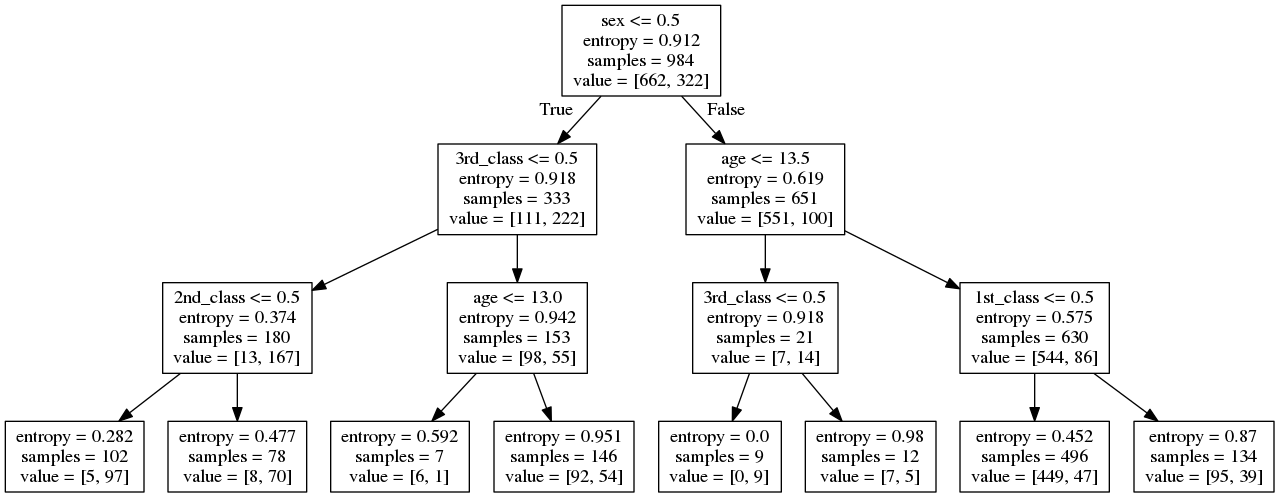

In [29]:
import io
dot_data = io.StringIO() 
sk.tree.export_graphviz(clf, out_file=dot_data, feature_names=['age','sex','1st_class','2nd_class','3rd_class']) 
(graph,) = pydot.graph_from_dot_data(dot_data.getvalue()) 
from IPython.core.display import Image 
Image(graph.create_png())

Let's measure Accuracy, precision, recall, f1 in the training set

In [11]:
from sklearn import metrics
def measure_performance(X,y,clf, show_accuracy=True, show_classification_report=True, show_confusion_matrix=True):
    y_pred=clf.predict(X)   
    if show_accuracy:
        print( "Accuracy:{0:.3f}".format(metrics.accuracy_score(y,y_pred)),"\n")

    if show_classification_report:
        print( "Classification report")
        print( metrics.classification_report(y,y_pred),"\n")
        
    if show_confusion_matrix:
        print( "Confusion matrix")
        print( metrics.confusion_matrix(y,y_pred),"\n")
        
measure_performance(X_train,y_train,clf, show_classification_report=False, show_confusion_matrix=False)

Accuracy:0.838 



For this example, we will use an extreme case of cross- validation, named leave-one-out cross-validation. For each instance in the training sample, we train on the rest of the sample, and evaluate the model built on the only instance left out. After performing as many classifications as training instances, we calculate the accuracy simply as the proportion of times our method correctly predicted the class of the left-out instance, and found it is a little lower (as we expected) than the resubstitution accuracy on the training set.

In [13]:
from sklearn.model_selection import cross_val_score, LeaveOneOut #model_selection replaces cross_validation
from scipy.stats.stats import sem

def loo_cv(X_train,y_train,clf):
    # Perform Leave-One-Out cross validation
    # We are performing 1313 classifications!
    loo = LeaveOneOut()
    scores=np.zeros(X_train[:].shape[0]) #rjm49 - list of zeroes that's as long as X_train
    #for train_index,test_index in loo(X_train):
    print(loo.split(X_train))
    first = True
    for train_index,test_index in loo.split(X_train):
        if first:
            print(train_index, test_index)
            first = False
        X_train_cv, X_test_cv= X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv= y_train[train_index], y_train[test_index]
        clf = clf.fit(X_train_cv,y_train_cv)
        y_pred=clf.predict(X_test_cv)
        scores[test_index]=sk.metrics.accuracy_score(y_test_cv.astype(int), y_pred.astype(int))
    print("Mean score: {0:.3f} (+/-{1:.3f})".format(np.mean(scores), sem(scores)))



In [14]:
loo_cv(X_train, y_train,clf)


<generator object BaseCrossValidator.split at 0x7ff353b68ba0>
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

### Random Forests

A common criticism to decision trees is that once the training set is divided after answering a question, it is not possible to reconsider this decision. For example, if we divide men and women, every subsequent question would be only about men or women, and the method could not consider another type of question (say, age less than a year, irrespective of the gender). Random Forests try to introduce some level of randomization in each step, proposing alternative trees and combining them to get the final prediction. These types of algorithms that consider several classifiers answering the same question are called ensemble methods. 

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_estimators=10,random_state=42)
clf_rf = clf_rf.fit(X_train,y_train)
#loo_cv(X_train,y_train,clf_rf)

To evaluate performance on future data, evaluate on the training set and test on the evaluation set

In [16]:
clf_dt=tree.DecisionTreeClassifier(criterion='entropy', max_depth=3,min_samples_leaf=5)
clf_dt.fit(X_train,y_train)
print("Decision tree:")
measure_performance(X_test,y_test,clf_dt)

print("Random forest:")
measure_performance(X_test,y_test,clf_rf)

#rjm49 -try your luck here... 
me = np.array([39, 0, 0, 1, 0]).reshape(1,-1)
print(clf_dt.predict_proba(me))
print(clf_rf.predict_proba(me))


Decision tree:
Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

        0.0       0.77      0.96      0.85       202
        1.0       0.88      0.54      0.67       127

avg / total       0.81      0.79      0.78       329
 

Confusion matrix
[[193   9]
 [ 59  68]] 

Random forest:
Accuracy:0.781 

Classification report
             precision    recall  f1-score   support

        0.0       0.78      0.91      0.84       202
        1.0       0.80      0.58      0.67       127

avg / total       0.78      0.78      0.77       329
 

Confusion matrix
[[183  19]
 [ 53  74]] 

[[ 0.1025641  0.8974359]]
[[ 0.8  0.2]]
